In [48]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [49]:
# KoBERT 모델 및 토크나이저 로드
model_name = "skt/kobert-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

max_length = 128  # KoBERT 최대 토큰 길이 설정

In [50]:
# 학습 데이터 로드
train_df = pd.read_csv("train (5).csv")

# 테스트 데이터 로드
test_df = pd.read_csv("test (4).csv")

print("결측치 개수 확인:")
print(train_df.isnull().sum())

# 🚨 NaN 값 제거 (필수)
train_df = train_df.dropna(subset=["class", "conversation"])
test_df = test_df.dropna(subset=["text"])

# 🚀 훈련 데이터 준비 (class 컬럼 그대로 사용)
X_train, y_train = train_df["conversation"].tolist(), train_df["class"].tolist()

# 🚀 테스트 데이터 준비
X_test, test_ids = test_df["text"].tolist(), test_df["idx"].tolist()



결측치 개수 확인:
Unnamed: 0      0
idx             0
class           0
conversation    0
dtype: int64


In [51]:
class ThreatDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128, is_test=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        input_ids = encoding["input_ids"].squeeze(0)  # (1, max_length) → (max_length,)
        attention_mask = encoding["attention_mask"].squeeze(0)

        if self.is_test:
            return {"input_ids": input_ids, "attention_mask": attention_mask}

        label = self.labels[idx]
        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": torch.tensor(label, dtype=torch.long)}

# Dataset 생성
train_dataset = ThreatDataset(X_train, y_train, tokenizer, max_length)
test_dataset = ThreatDataset(X_test, tokenizer=tokenizer, max_length=max_length, is_test=True)

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [52]:
class KoBERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes=5):
        super(KoBERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)  # KoBERT 출력 차원 768 → 클래스 수

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

# 모델 생성
num_classes = 5  # 5개 클래스 분류
model = KoBERTClassifier(bert_model, num_classes).to(device)

Epoch 1/10 (Validation): 100%|██████████| 30/30 [00:07<00:00,  3.92it/s, val_loss=1.3014]


Epoch [1/10], Train Loss: 1.4875, Val Loss: 1.3109, Val Accuracy: 0.4405


Epoch 2/10 (Validation): 100%|██████████| 30/30 [00:07<00:00,  3.94it/s, val_loss=1.1150]


Epoch [2/10], Train Loss: 1.3103, Val Loss: 1.2212, Val Accuracy: 0.4635


Epoch 3/10 (Validation): 100%|██████████| 30/30 [00:07<00:00,  3.93it/s, val_loss=1.1152]


Epoch [3/10], Train Loss: 1.2354, Val Loss: 1.1605, Val Accuracy: 0.4969


Epoch 4/10 (Validation): 100%|██████████| 30/30 [00:07<00:00,  3.96it/s, val_loss=0.9900]


Epoch [4/10], Train Loss: 1.1589, Val Loss: 1.0837, Val Accuracy: 0.5532


Epoch 5/10 (Validation): 100%|██████████| 30/30 [00:07<00:00,  3.95it/s, val_loss=1.1194]


Epoch [5/10], Train Loss: 1.1077, Val Loss: 1.1675, Val Accuracy: 0.5104


Epoch 6/10 (Validation): 100%|██████████| 30/30 [00:07<00:00,  3.95it/s, val_loss=0.9042]


Epoch [6/10], Train Loss: 1.0612, Val Loss: 1.0492, Val Accuracy: 0.5720


Epoch 7/10 (Validation): 100%|██████████| 30/30 [00:07<00:00,  3.94it/s, val_loss=0.9796]


Epoch [7/10], Train Loss: 0.9838, Val Loss: 1.1334, Val Accuracy: 0.5522


Epoch 8/10 (Validation): 100%|██████████| 30/30 [00:07<00:00,  3.95it/s, val_loss=1.0193]


Epoch [8/10], Train Loss: 0.9550, Val Loss: 1.1532, Val Accuracy: 0.5491


Epoch 9/10 (Validation): 100%|██████████| 30/30 [00:07<00:00,  3.92it/s, val_loss=0.8724]


Epoch [9/10], Train Loss: 0.8746, Val Loss: 1.0805, Val Accuracy: 0.5731


Epoch 10/10 (Validation): 100%|██████████| 30/30 [00:07<00:00,  3.93it/s, val_loss=0.9655]


Epoch [10/10], Train Loss: 0.8290, Val Loss: 1.0790, Val Accuracy: 0.5929


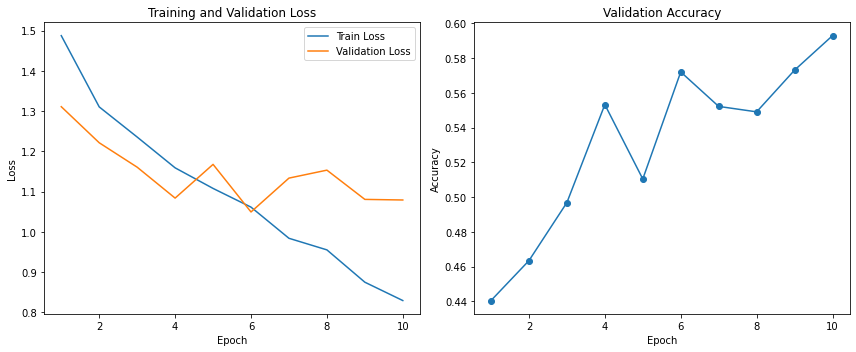

Final Validation Accuracy: 0.5929

Classification Report on Validation Data:
              precision    recall  f1-score   support

          협박       0.44      0.58      0.50       169
          갈취       0.59      0.42      0.49       188
    직장 내 괴롭힘       0.54      0.73      0.62       196
      기타 괴롭힘       0.54      0.34      0.41       205
       일반 대화       0.86      0.90      0.88       200

    accuracy                           0.59       958
   macro avg       0.59      0.59      0.58       958
weighted avg       0.60      0.59      0.58       958



In [53]:
from sklearn.model_selection import train_test_split

# 손실 함수 및 최적화 기법 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

from sklearn.model_selection import train_test_split

# 훈련 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Dataset 생성
train_dataset = ThreatDataset(X_train, y_train, tokenizer, max_length)
val_dataset = ThreatDataset(X_val, y_val, tokenizer, max_length)
test_dataset = ThreatDataset(X_test, tokenizer=tokenizer, max_length=max_length, is_test=True)

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 학습 및 검증 함수 수정
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # 훈련
        model.train()
        total_train_loss = 0
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
        for batch in train_progress_bar:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            train_progress_bar.set_postfix({"train_loss": f"{loss.item():.4f}"})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 검증
        model.eval()
        total_val_loss = 0
        val_predictions = []
        val_true_labels = []
        
        with torch.no_grad():
            val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")
            for batch in val_progress_bar:
                input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
                
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                val_predictions.extend(preds.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

                val_progress_bar.set_postfix({"val_loss": f"{loss.item():.4f}"})

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

# 학습 및 검증 실행
train_losses, val_losses, val_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# 학습 및 검증 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# 최종 검증 데이터 평가
final_val_predictions = evaluate_model(model, val_loader, class_names)
final_val_accuracy = accuracy_score(y_val, final_val_predictions)
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print("\nClassification Report on Validation Data:")
print(classification_report(y_val, final_val_predictions, target_names=class_names))

In [54]:
from sklearn.metrics import accuracy_score, classification_report

# 평가 함수 정의 (정확도 및 상세 리포트 출력)
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
            )

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())

    return all_preds  # ✅ 예측된 값만 반환

# 클래스 이름 리스트 (라벨 순서에 맞게 설정)
class_names = ["협박", "갈취", "직장 내 괴롭힘", "기타 괴롭힘", "일반 대화"]

# 평가 실행
evaluate_model(model, test_loader, class_names)




[3,
 3,
 0,
 1,
 2,
 0,
 0,
 3,
 3,
 2,
 0,
 3,
 2,
 4,
 2,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 2,
 4,
 3,
 0,
 3,
 2,
 4,
 3,
 0,
 0,
 2,
 3,
 1,
 0,
 2,
 0,
 3,
 2,
 1,
 4,
 4,
 2,
 1,
 3,
 3,
 2,
 2,
 0,
 1,
 0,
 3,
 3,
 1,
 0,
 0,
 2,
 2,
 2,
 4,
 0,
 4,
 1,
 0,
 0,
 3,
 2,
 1,
 0,
 0,
 4,
 2,
 0,
 4,
 1,
 4,
 3,
 0,
 2,
 2,
 3,
 0,
 2,
 1,
 2,
 0,
 3,
 0,
 2,
 2,
 2,
 0,
 2,
 3,
 1,
 0,
 2,
 0,
 2,
 0,
 3,
 1,
 2,
 3,
 4,
 0,
 3,
 1,
 3,
 2,
 0,
 3,
 2,
 2,
 3,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 3,
 3,
 2,
 2,
 3,
 3,
 0,
 4,
 0,
 2,
 0,
 4,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 4,
 4,
 2,
 3,
 2,
 2,
 0,
 3,
 2,
 3,
 0,
 0,
 3,
 2,
 2,
 3,
 2,
 1,
 0,
 2,
 2,
 2,
 3,
 0,
 2,
 2,
 0,
 0,
 0,
 4,
 3,
 3,
 1,
 3,
 2,
 2,
 1,
 2,
 0,
 3,
 1,
 0,
 4,
 0,
 0,
 4,
 0,
 0,
 2,
 3,
 2,
 2,
 0,
 3,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 3,
 0,
 4,
 0,
 0,
 0,
 1,
 2,
 0,
 4,
 0,
 0,
 4,
 2,
 3,
 0,
 4,
 1,
 3,
 2,
 3,
 3,
 0,
 2,
 3,
 3,
 0,
 2,
 3,
 2,
 4,
 1,
 2,
 3,
 2,
 0,


In [55]:
# 예측 함수 정의
def predict(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask = batch["input_ids"].to(device), batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())

    return predictions

# 테스트 데이터 예측 수행
test_predictions = evaluate_model(model, test_loader, class_names)

# ✅ 예측 결과를 Submission 파일로 저장
submission_df = pd.DataFrame({"idx": test_ids, "target": test_predictions})
submission_df.to_csv("submission.csv", index=False)

print("✅ Submission 파일이 생성되었습니다: submission.csv")


✅ Submission 파일이 생성되었습니다: submission.csv
